In [1]:
import os
import itertools
import random
import copy
import json

import numpy as np

from models import Discriminator, weights_init_normal, GeneratorResNet
from utils import ReplayBuffer, LambdaLR

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

from easydict import EasyDict as edict

import torch
from torch.autograd import Variable
import torch.nn as nn

import sys
from my_utils import load_dataset, LoaderSampler, tensor2img, get_Z_pushed_loader_stats, calculate_cost
from fid_score import calculate_frechet_distance

batchsize = 32
lambda_id = 20.0

opt = edict({
    "devices": [4],
    "epoch": 0,
    "n_epochs": 200,
    "decay_epoch": 100,
    
    "batch_size": batchsize,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,

    "n_residual_blocks": 9,
    "lambda_cyc": 10.0,
    "lambda_id": lambda_id,

    "image_save_interval": (500 * 64) // batchsize,
    "model_save_interval": (500 * 64) // batchsize
})

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

DATASET1, DATASET1_PATH = 'celeba_female', '../../../../data/img_align_celeba'
DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../../../data/aligned_anime_faces'

IMG_SIZE = 64

BEST_FID = np.inf

OUTPUT_PATH = '../../../checkpoints/cyclegan_pytorch/{}_{}_{}_lambda_{}'.format(DATASET1, DATASET2, IMG_SIZE, lambda_id)

writer = SummaryWriter(os.path.join(OUTPUT_PATH, "tensorboard"))

path_to_save_models = os.path.join(OUTPUT_PATH, "models")
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)


input_shape = (3, IMG_SIZE, IMG_SIZE)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, opt.n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

device = f'cuda:{opt.devices[0]}'

G_AB = G_AB.to(device)
G_BA = G_BA.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)

criterion_GAN.to(device)
criterion_cycle.to(device)
criterion_identity.to(device)

opt_seed = 0x000000
print("using random seed:", opt_seed)
random.seed(opt_seed)
np.random.seed(opt_seed)
torch.manual_seed(opt_seed)
torch.cuda.manual_seed_all(opt_seed)
# Initialize weights
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

D_A_output_shape = D_A.output_shape

G_AB = nn.DataParallel(G_AB, device_ids=opt.devices)
G_BA = nn.DataParallel(G_BA, device_ids=opt.devices)
D_A = nn.DataParallel(D_A, device_ids=opt.devices)
D_B = nn.DataParallel(D_B, device_ids=opt.devices)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)

Tensor = torch.cuda.FloatTensor

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats


opt_seed = 0x000000
random.seed(opt_seed)
np.random.seed(opt_seed)
torch.manual_seed(opt_seed)
torch.cuda.manual_seed_all(opt_seed)

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=opt.batch_size)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=opt.batch_size)

n_batches = min(len(train_loader_a), len(train_loader_b))

X_sampler = LoaderSampler(train_loader_a, device=device)
X_test_sampler = LoaderSampler(test_loader_a, device=device)
Y_sampler = LoaderSampler(train_loader_b, device=device)
Y_test_sampler = LoaderSampler(test_loader_b, device=device)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_fixed = []
Y_fixed = []
X_test_fixed = []
Y_test_fixed = []

for i in range(10):
    X_fixed.append(X_sampler.sample(1))
    Y_fixed.append(Y_sampler.sample(1))

    X_test_fixed.append(X_test_sampler.sample(1))
    Y_test_fixed.append(Y_test_sampler.sample(1))
    
X_fixed = torch.cat(X_fixed, dim=0)
Y_fixed = torch.cat(Y_fixed, dim=0)
X_test_fixed = torch.cat(X_test_fixed, dim=0)
Y_test_fixed = torch.cat(Y_test_fixed, dim=0)
# ----------
#  Training
# ----------
best_iter_fid = 0
best_iter_cost = 0

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

MAX_STEPS = opt.n_epochs * n_batches

previous_epoch = 0

using random seed: 0


Plotting, step = 272001, best FID = 22.88826102955568
mode = train


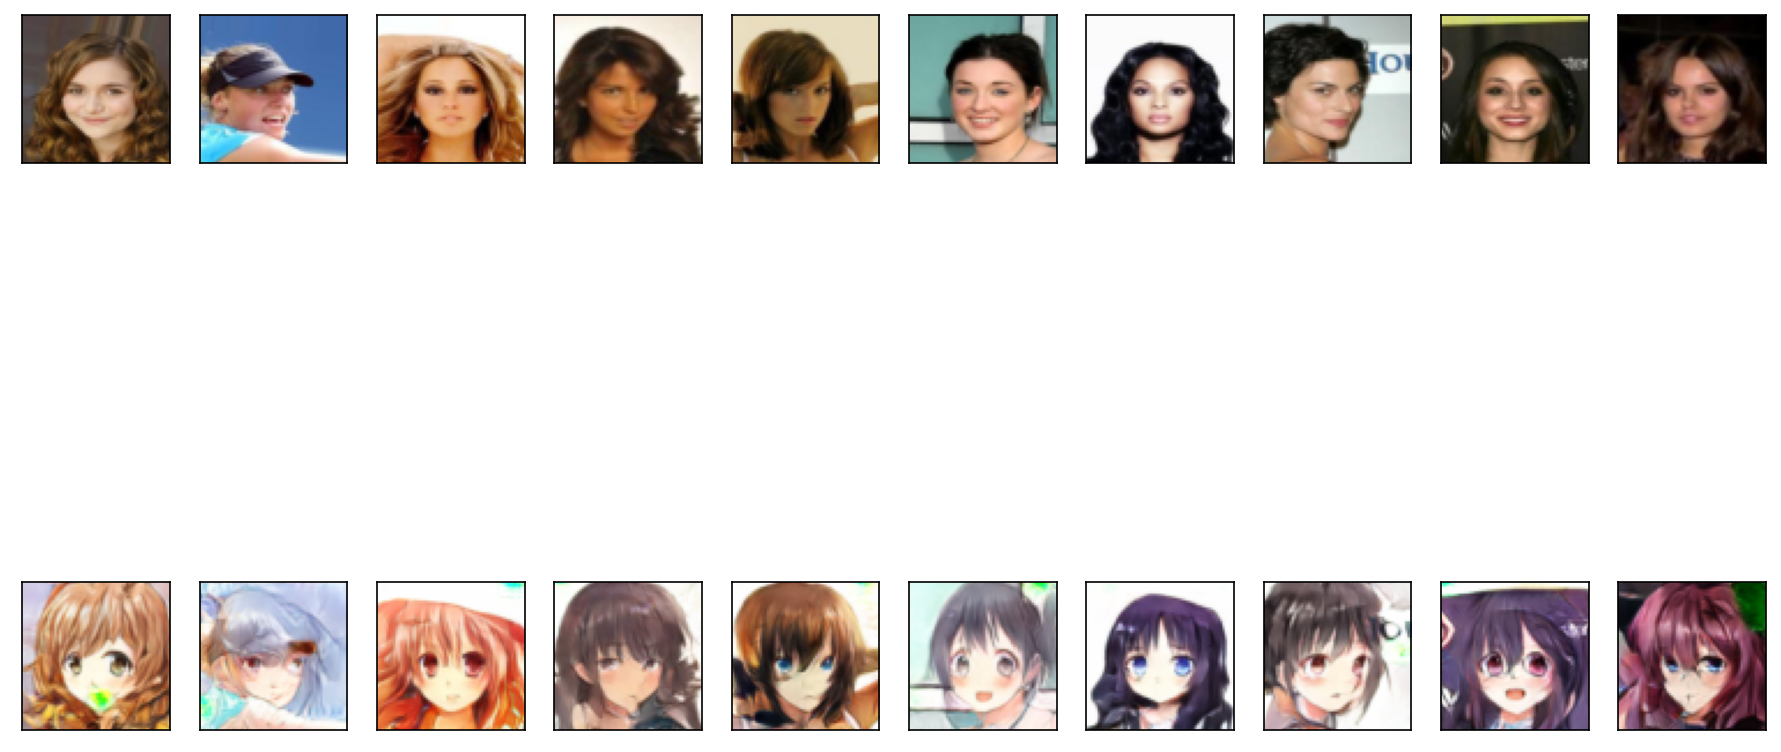

mode = test


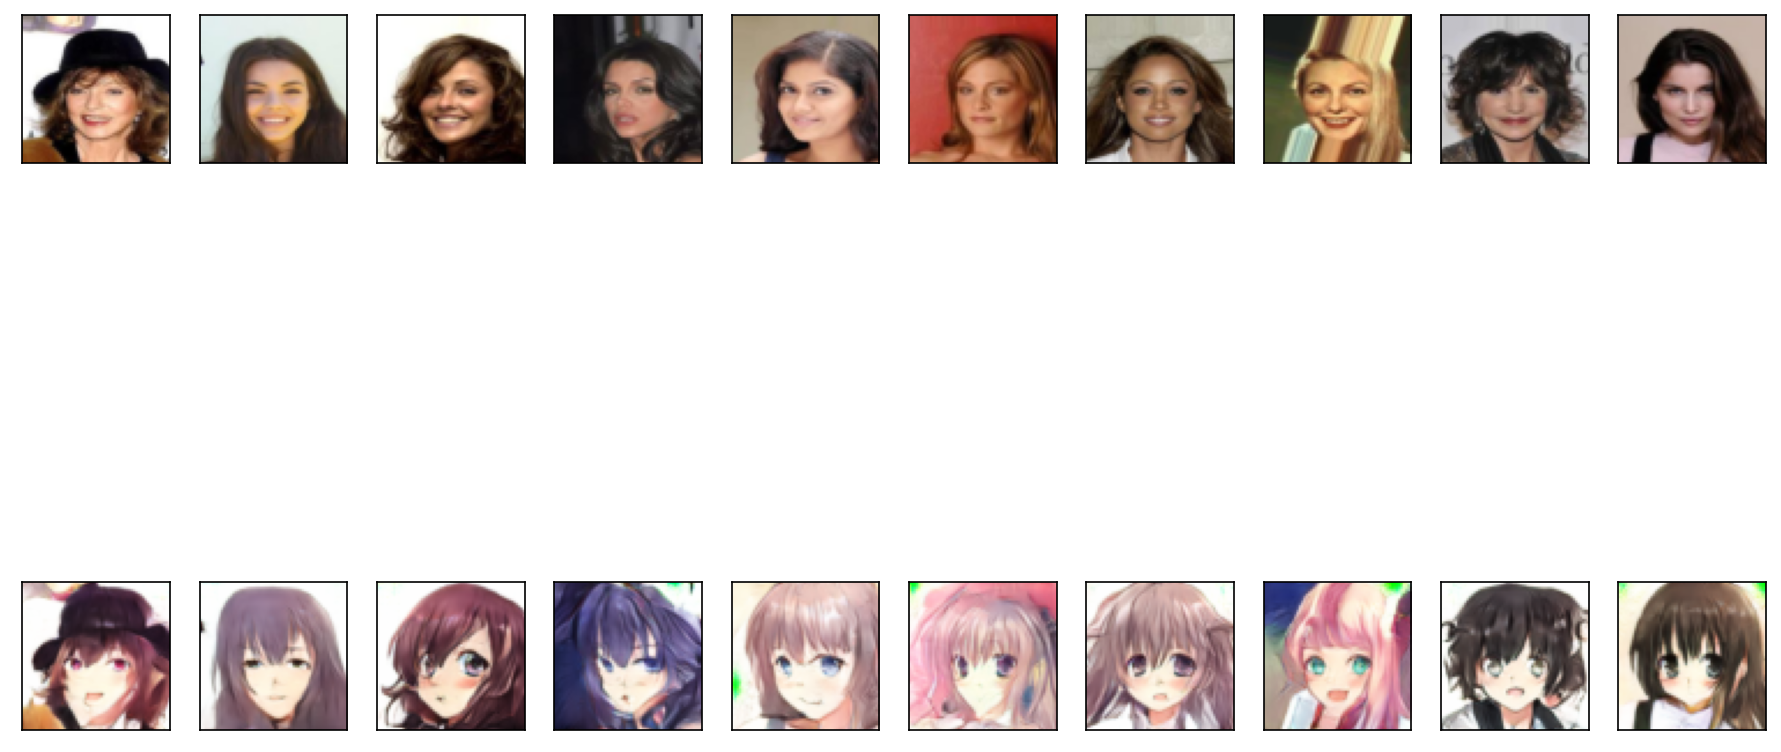

Computing cost


370it [00:26, 14.02it/s]


Cost = 0.3031250556215856, best cost = 0.19915308972307372, best iter = 0
Computing FID
FID = 26.474792060027767, best FID = 22.88826102955568, best iter = 216000


KeyboardInterrupt: 

In [2]:
best_cost = np.inf

for step in range(MAX_STEPS):

    epoch = step // n_batches + 1

    A = X_sampler.sample(opt.batch_size)
    B = Y_sampler.sample(opt.batch_size)

    # Set model input
    real_A = Variable(A)
    real_B = Variable(B)

    # Adversarial ground truths
    valid = Variable(Tensor(np.ones((real_A.size(0), 1, 4, 4))), requires_grad=False).to(device)
    fake = Variable(Tensor(np.zeros((real_A.size(0), 1, 4, 4))), requires_grad=False).to(device)

    # ------------------
    #  Train Generators
    # ------------------

    G_AB.train()
    G_BA.train()

    optimizer_G.zero_grad()

    # Identity loss
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2

    # GAN loss
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

    # Cycle loss
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

    # Total loss
    loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

    loss_G.backward()
    optimizer_G.step()

    # -----------------------
    #  Train Discriminator A
    # -----------------------

    optimizer_D_A.zero_grad()

    # Real loss
    loss_real = criterion_GAN(D_A(real_A), valid)
    # Fake loss (on batch of previously generated samples)
    fake_A_ = fake_A_buffer.push_and_pop(fake_A)
    loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
    # Total loss
    loss_D_A = (loss_real + loss_fake) / 2

    loss_D_A.backward()
    optimizer_D_A.step()

    # -----------------------
    #  Train Discriminator B
    # -----------------------

    optimizer_D_B.zero_grad()

    # Real loss
    loss_real = criterion_GAN(D_B(real_B), valid)
    # Fake loss (on batch of previously generated samples)
    fake_B_ = fake_B_buffer.push_and_pop(fake_B)
    loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
    # Total loss
    loss_D_B = (loss_real + loss_fake) / 2

    loss_D_B.backward()
    optimizer_D_B.step()

    loss_D = (loss_D_A + loss_D_B) / 2

    # --------------
    #  Log Progress
    # --------------

    # Determine approximate time left
    writer.add_scalar('Loss D',
                      loss_D.item(),
                      step + 1)

    writer.add_scalar('Loss G',
                      loss_G.item(),
                      step + 1)

    writer.add_scalar('Loss GAN',
                      loss_GAN.item(),
                      step + 1)

    writer.add_scalar('Loss identity',
                      loss_identity.item(),
                      step + 1)

    writer.add_scalar('Loss cycle',
                      loss_cycle.item(),
                      step + 1)

    if step % opt.image_save_interval == 0:
        clear_output(wait=True)
        print(f'Plotting, step = {step + 1}, best FID = {BEST_FID}')

        G_AB.eval()
        G_BA.eval()
        AB_train = G_AB(X_fixed).detach()
        AB_test = G_AB(X_test_fixed).detach()

        Y_fakes = [tensor2img(AB_train)]
        Y_test_fakes = [tensor2img(AB_test)]

        modes = ["train", "test"]

        real_X_numpy = tensor2img(X_fixed)
        real_X_test_numpy = tensor2img(X_test_fixed)
        real_Y_numpy = tensor2img(Y_fixed)
        real_Y_test_numpy = tensor2img(Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(2, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[1][j].imshow(Y_tensor[j])
                axes[1][j].get_xaxis().set_visible(False)
                axes[1][j].get_yaxis().set_visible(False)

            for j in range(10):
                cur_img = Y_fake_tensor[0][j]

                axes[1][j].imshow(cur_img)
                axes[1][j].get_xaxis().set_visible(False)
                axes[1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            writer.add_figure(f'Step {step + 1}, {modes[t]}',
                              fig,
                              global_step=step + 1)
            plt.close(fig)

        G_AB.train()
        G_BA.train()

    if step % opt.model_save_interval == 0:
        G_AB.eval()
        G_BA.eval()
        D_A.eval()
        D_B.eval()

        G_AB_module = copy.deepcopy(G_AB.module).cpu()
        G_BA_module = copy.deepcopy(G_BA.module).cpu()
        D_A_module = copy.deepcopy(D_A.module).cpu()
        D_B_module = copy.deepcopy(D_B.module).cpu()

        checkpoint = {
            'netG_A_B': G_AB_module.state_dict(),
            'netG_B_A': G_BA_module.state_dict(),
            'netD_A': D_A_module.state_dict(),
            'netD_B': D_B_module.state_dict(),
            'optimizers_gen': optimizer_G.state_dict(),
            'optimizers_dis_a': optimizer_D_A.state_dict(),
            'optimizers_dis_b': optimizer_D_B.state_dict()
        }

        path_to_save_cur_model = os.path.join(path_to_save_models, f"model_iter_{step}.pth")
        torch.save(checkpoint, path_to_save_cur_model)

        print('Computing cost')
        cost = calculate_cost(G_AB, X_test_sampler.loader, device=device, cost_type='mse', verbose=True)
        print(f"Cost = {cost}, best cost = {best_cost}, best iter = {best_iter_cost}")
        writer.add_scalar('test cost',
                          cost,
                          step + 1)

        if cost < best_cost:
            best_cost = cost
            best_iter = best_iter_cost
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(G_AB, X_test_sampler.loader, device)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {BEST_FID}, best iter = {best_iter_fid}")
        writer.add_scalar('test fid',
                          fid,
                          step + 1)
        
        if fid < BEST_FID:
            BEST_FID = fid
            best_iter_fid = step

        G_AB.train()
        G_BA.train()
        D_A.train()
        D_B.train()

    # Update learning rates
    if epoch > previous_epoch:
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

    previous_epoch = epoch